# (Optional) Colab Setup
If you aren't using Colab, you can delete the following code cell. This is just to help students with mounting to Google Drive to access the other .py files and downloading the data, which is a little trickier on Colab than on your local machine using Jupyter. 

In [1]:
# you will be prompted with a window asking to grant permissions
COLAB = False
if COLAB:
    from google.colab import drive
    drive.mount("/content/drive")

In [2]:
# fill in the path in your Google Drive in the string below. Note: do not escape slashes or spaces
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
if COLAB:
    work_dir = "/content/drive/My Drive/Your/Assignment3/path/"
else:
    work_dir = "/home/changl25/private/assignment31/"
if not os.path.exists(work_dir) and COLAB:
  !ln -s "/content/drive/My Drive/Your/Assignment3/path/" $work_dir # TODO: Fill your Assignment 3 path
os.chdir(work_dir)
!pwd

/home/changl25/private/assignment31


# Data Setup

The first thing to do is implement a dataset class to load rotated CIFAR10 images with matching labels. Since there is already a CIFAR10 dataset class implemented in `torchvision`, we will extend this class and modify the `__get_item__` method appropriately to load rotated images.

Each rotation label should be an integer in the set {0, 1, 2, 3} which correspond to rotations of 0, 90, 180, or 270 degrees respectively.

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random


def rotate_img(img, rot):
    rot_lst = [1 , 2, 3]
    if rot == 0: # 0 degrees rotation
        return img
    # TODO: Implement rotate_img() - return the rotated img 
    elif rot in rot_lst:
        return transforms.functional.rotate(img, rot * 90)
    else:
        raise ValueError(f'rotation is {rot}, rotation should be 0, 90, 180, or 270 degrees')


class CIFAR10Rotation(torchvision.datasets.CIFAR10):

    def __init__(self, root, train, download, transform) -> None:
        super().__init__(root=root, train=train, download=download, transform=transform)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index: int):
        image, cls_label = super().__getitem__(index)

        # randomly select image rotation
        rotation_label = random.choice([0, 1, 2, 3])
        image_rotated = rotate_img(image, rotation_label)

        rotation_label = torch.tensor(rotation_label).long()
        return image, image_rotated, rotation_label, torch.tensor(cls_label).long()

In [4]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

batch_size = 128

trainset = CIFAR10Rotation(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = CIFAR10Rotation(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

print("train size: ", len(trainloader), "test size: ", len(testloader))

Files already downloaded and verified
Files already downloaded and verified
train size:  391 test size:  79


### Show some example images and rotated images with labels:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


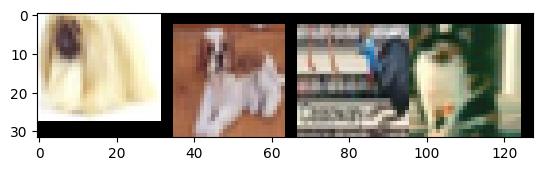

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Class labels:  dog   dog   bird  cat  


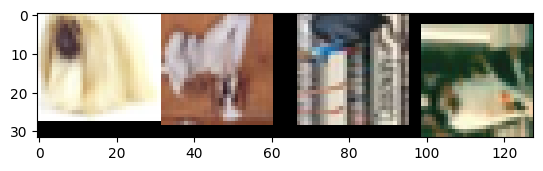

Rotation labels:  0     180   90    90   


In [5]:
import matplotlib.pyplot as plt

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

rot_classes = ('0', '90', '180', '270')


def imshow(img):
    # unnormalize
    img = transforms.Normalize((0, 0, 0), (1/0.2023, 1/0.1994, 1/0.2010))(img)
    img = transforms.Normalize((-0.4914, -0.4822, -0.4465), (1, 1, 1))(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, rot_images, rot_labels, labels = next(dataiter)

# print images and rotated images
img_grid = imshow(torchvision.utils.make_grid(images[:4], padding=0))
print('Class labels: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))
img_grid = imshow(torchvision.utils.make_grid(rot_images[:4], padding=0))
print('Rotation labels: ', ' '.join(f'{rot_classes[rot_labels[j]]:5s}' for j in range(4)))

# Evaluation code

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [7]:
import time

def run_test(net, testloader, criterion, task):
    correct = 0
    total = 0
    avg_test_loss = 0.0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for images, images_rotated, labels, cls_labels in testloader:
            if task == 'rotation':
              images, labels = images_rotated.to(device), labels.to(device)
            elif task == 'classification':
              images, labels = images.to(device), cls_labels.to(device)
            # TODO: Calculate outputs by running images through the network
            # The class with the highest energy is what we choose as prediction
            
            outputs = net(images)
            # _, outputs = torch.topk(outputs, 1)
            # loss
            avg_test_loss += criterion(outputs, labels)  / len(testloader)
            
            total += outputs.size(0)
            _, pred = torch.topk(outputs, 1, dim=1)
            pred = pred.squeeze()
            correct += (pred == labels).sum().item()

    print('TESTING:')
    print(f'Accuracy of the network on the 10000 test images: {100 * correct / total:.2f} %')
    print(f'Average loss on the 10000 test images: {avg_test_loss:.3f}')
    return correct / total

In [8]:
def adjust_learning_rate(optimizer, epoch, init_lr, decay_epochs=30):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = init_lr * (0.1 ** (epoch // decay_epochs))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

# Train a ResNet18 on the rotation task

### In this section, we will train a ResNet18 model on the rotation task. The input is a rotated image and the model predicts the rotation label. See the Data Setup section for details.

In [9]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

net = resnet18(num_classes=4)
net = net.to(device)

In [10]:
import torch.optim as optim
criterion = None
optimizer = None

# TODO: Define criterion and optimizer
#
optimizer = torch.optim.Adam(net.parameters(), weight_decay=0.0008)
criterion = nn.CrossEntropyLoss().to(device)
#

In [11]:
# Both the self-supervised rotation task and supervised CIFAR10 classification are
# trained with the CrossEntropyLoss, so we can use the training loop code.

def train(net, trainloader, criterion, optimizer, num_epochs, decay_epochs, init_lr, task, scheduler_cls=None, scheduler_params=None, data_num=None):
    unchanged_epoch_num = 0
    best_acc = 0
    best_epoch = 0
    for param_group in optimizer.param_groups:
        param_group['lr'] = init_lr
    scheduler = None
    if scheduler_cls is not None and scheduler_params is not None:
        scheduler = scheduler_cls(optimizer, **scheduler_params)
    for epoch in range(num_epochs):  # loop over the dataset multiple times

        if unchanged_epoch_num > decay_epochs:
            print("Too many epochs without acc increase!")
            break
        running_loss = 0.0
        running_correct = 0.0
        running_total = 0.0
        start_time = time.time()

        net.train()

        
        for i, (imgs, imgs_rotated, rotation_label, cls_label) in enumerate(trainloader, 0):
        #     adjust_learning_rate(optimizer, epoch, init_lr, decay_epochs)
            if data_num is not None and i * batch_size > data_num:
                break
        # TODO: Set the data to the correct device; Different task will use different inputs and labels
            if task == 'rotation':
                image, labels = imgs_rotated.to(device), rotation_label.to(device)
            elif task == 'classification':
                image, labels = imgs.to(device), cls_label.to(device)    
        # TODO: Zero the parameter gradients
            optimizer.zero_grad()
        # TODO: forward + backward + optimize
            output = net(image)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
                
            # TODO: Get predicted results
            _, pred = torch.topk(output, 1, dim=1)
            pred = pred.squeeze()
            # print statistics
            print_freq = 100
            running_loss += loss.item()

            # calc acc
            running_correct += (pred == labels).sum().item()
            running_total += labels.size(0)

            if i % print_freq == (print_freq - 1):    # print every 2000 mini-batches
                print(f"[{epoch + 1}, {i + 1:5d}] lr: {optimizer.param_groups[0]['lr']} loss: {running_loss / print_freq:.3f} acc: {100*running_correct / running_total:.2f} time: {time.time() - start_time:.2f}")
                running_loss, running_correct, running_total = 0.0, 0.0, 0.0
                start_time = time.time()

        if scheduler is not None:
            scheduler.step()
        
        # TODO: Run the run_test() function after each epoch; Set the model to the evaluation mode.
        #
        net.eval()
        acc = run_test(net, testloader, criterion, task)
        if acc > best_acc:
            best_acc = acc 
            unchanged_epoch_num = 0
            best_epoch = i
        else:
            unchanged_epoch_num += 1
        print(f"Current best accuracy of the testing is {best_acc * 100}% at epoch {epoch}")
    print('Finished Training')

In [12]:
num_epochs=50
decay_epochs=15
init_lr=1e-4
task='rotation'
scheduler_cls = torch.optim.lr_scheduler.StepLR
scheduler_params = {'step_size': 30, 'gamma': 0.1}

net = resnet18(num_classes=4)
net = net.to(device)
optimizer = torch.optim.Adam(net.parameters(), weight_decay=0.0008)
criterion = nn.CrossEntropyLoss().to(device)

In [ ]:
train(net, trainloader, criterion, optimizer, num_epochs=num_epochs, decay_epochs=decay_epochs, init_lr=init_lr, task=task)

In [ ]:
# TODO: Save the model
net_name = "resnet18_lr{}_epoch{}_{}.pth.tar".format(init_lr, num_epochs, task)
save_path = os.path.join(work_dir, "model")
os.makedirs(save_path, exist_ok=True)
torch.save(net.state_dict(), os.path.join(save_path, net_name))

In [ ]:
num_epochs=100
decay_epochs=15
init_lr=1e-1
task='rotation'
scheduler_cls = torch.optim.lr_scheduler.StepLR
scheduler_params = {'step_size': 30, 'gamma': 0.2}

net = resnet18(num_classes=4)
net = net.to(device)
optimizer = torch.optim.SGD(net.parameters(), lr= 0.1, weight_decay=0.0005, momentum=0.9)
criterion = nn.CrossEntropyLoss().to(device)

train(net, trainloader, criterion, optimizer, num_epochs=num_epochs, decay_epochs=decay_epochs, init_lr=init_lr, task=task)


In [ ]:
net_name = "resnet18_lr{}_epoch{}_{}.pth.tar".format(init_lr, num_epochs, task)
save_path = os.path.join(work_dir, "model")
os.makedirs(save_path, exist_ok=True)
torch.save(net.state_dict(), os.path.join(save_path, net_name))

In [13]:
import torch.nn as nn
import torch.nn.functional as F
from collections import OrderedDict
from torchvision.models import resnet18

# TODO: Load the pre-trained ResNet18 model
#
model_path = "/home/changl25/private/assignment31/model/resnet18_lr0.1_epoch100_rotation.pth.tar"
net = resnet18(num_classes=4).to(device)
net.load_state_dict(torch.load(model_path, map_location=device))
_ = run_test(net, testloader, criterion, task)


TESTING:
Accuracy of the network on the 10000 test images: 78.32 %
Average loss on the 10000 test images: 0.551


# Fine-tuning on the pre-trained model
### In this section, we will load the pre-trained ResNet18 model and fine-tune on the classification task. We will freeze all previous layers except for the 'layer4' block and 'fc' layer.

In [14]:
def load_layers(net, pretrained_dict, layers):

    new_state_dict = OrderedDict() 
    for name, module in net.named_modules():
        
        if any(name.startswith(layer) for layer in layers):
            for key, value in module.named_parameters(recurse=False):
                key_whole = f"{name}.{key}"
                if isinstance(key, nn.Conv2d):
                    if "weight" in key:
                        nn.init.kaiming_normal_(value, mode='fan_out', nonlinearity='relu')
                elif isinstance(key, nn.BatchNorm2d):
                    if "weight" in key:
                        nn.init.constant_(value, 1)
                    else:
                        nn.init.constant_(value, 0)
                elif isinstance(key, nn.Linear):
                    if "weight" in key:
                        nn.init.xavier_normal_(value)
                    if "bias" in key and value is not None:
                        nn.init.constant_(value, 0.0)
                new_state_dict[key_whole] = value
        else:
            for key, value in module.named_parameters(recurse=False):
                key_whole = f"{name}.{key}"
                new_state_dict[key_whole] = pretrained_dict[key_whole]
    net.load_state_dict(new_state_dict, strict=False)
    return net

In [15]:
# TODO: Freeze all previous layers; only keep the 'layer4' block and 'fc' layer trainable
def freeze_layers(net, frozen_layers):
    print(frozen_layers)
    for name, parameters in net.named_parameters():
        module_name = name.split(".")[0]
        if module_name in frozen_layers:
            parameters.requires_grad = True 
        else:
            parameters.requires_grad = False
    return net

In [16]:
def randomize_net(net):
    for module in net.modules():
        if isinstance(module, nn.Conv2d):
            nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
        elif isinstance(module, nn.BatchNorm2d):
            nn.init.constant_(module.weight, 1)
            nn.init.constant_(module.bias, 0)
        elif isinstance(module, nn.Linear):
            nn.init.xavier_normal_(module.weight)
            if module.bias is not None:
                nn.init.constant_(module.bias, 0.0)
    return net

In [ ]:
for name, module in net.named_modules():
    print("name: ", name)
    print("module.children: ", list(module.children()))
    print("module.module: ", list(module.modules()))
    print("module.keys: ", module.state_dict().keys())
    print("module.values: ", module.state_dict().values())
    print("module.parameters: ")

In [62]:
frozen_layers = ["layer4", "fc"]
model_path = "/home/changl25/private/assignment31/model/resnet18_lr0.1_epoch100_rotation.pth.tar"
net = resnet18(num_classes=10).to(device)
net = load_layers(net, torch.load(model_path, map_location=device), frozen_layers)

net = freeze_layers(net, frozen_layers)

['layer4', 'fc']


In [ ]:
# Print all the trainable parameters
params_to_update = net.parameters()
print("Params to learn:")
params_to_update = []
for name,param in net.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

In [ ]:
num_epochs=100
decay_epochs=15
init_lr=5 * 1e-5
task='classification'
scheduler_cls = torch.optim.lr_scheduler.StepLR
scheduler_params = {'step_size': 30, 'gamma': 0.2}
optimizer = torch.optim.Adam(net.parameters(), weight_decay=0.0008)
# optimizer = torch.optim.SGD(net.parameters(), lr= init_lr, weight_decay=0.0005, momentum=0.9)
criterion = nn.CrossEntropyLoss().to(device)


In [ ]:
train(net, trainloader, criterion, optimizer, num_epochs=num_epochs, decay_epochs=decay_epochs, init_lr=init_lr, task=task, \
    scheduler_cls=scheduler_cls, scheduler_params=scheduler_params)

In [ ]:
net_name = "resnet18_pretrained_part_lr{}_epoch{}_{}.pth.tar".format(init_lr, num_epochs, task)
save_path = os.path.join(work_dir, "model")
os.makedirs(save_path, exist_ok=True)
torch.save(net.state_dict(), os.path.join(save_path, net_name))

# Fine-tuning on the randomly initialized model
### In this section, we will randomly initialize a ResNet18 model and fine-tune on the classification task. We will freeze all previous layers except for the 'layer4' block and 'fc' layer.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

# TODO: Randomly initialize a ResNet18 model
#
net = resnet18(num_classes=4, pretrained=False).to(device)
net = randomize_net(net)

In [ ]:
# TODO: Freeze all previous layers; only keep the 'layer4' block and 'fc' layer trainable
# To do this, you should set requires_grad=False for the frozen layers.
#
frozen_layers = ["layer4", "fc"]
net = freeze_layers(net, frozen_layers)
#

In [ ]:
# Print all the trainable parameters
params_to_update = net.parameters()
print("Params to learn:")
params_to_update = []
for name,param in net.named_parameters():
    if param.requires_grad == True:
        print(f"{name}: True")
        params_to_update.append(param)

In [ ]:
# TODO: Define criterion and optimizer
# Note that your optimizer only needs to update the parameters that are trainable.
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(params_to_update, weight_decay=0.008)

In [ ]:
train(net, trainloader, criterion, optimizer, num_epochs=num_epochs, decay_epochs=decay_epochs, init_lr=init_lr, task=task, \
    scheduler_cls=scheduler_cls, scheduler_params=scheduler_params)

In [ ]:
net_name = "resnet18_random_part_lr{}_epoch{}_{}.pth.tar".format(init_lr, num_epochs, task)
save_path = os.path.join(work_dir, "model")
os.makedirs(save_path, exist_ok=True)
torch.save(net.state_dict(), os.path.join(save_path, net_name))

# Supervised training on the pre-trained model
### In this section, we will load the pre-trained ResNet18 model and re-train the whole model on the classification task.

In [ ]:
# TODO: Load the pre-trained ResNet18 model
#
frozen_layers = ["layer4", "fc"]
model_path = "/home/changl25/private/assignment31/model/resnet18_lr0.1_epoch100_rotation.pth.tar"
net = resnet18(num_classes=10).to(device)
net = load_layers(net, torch.load(model_path, map_location=device), frozen_layers)

In [ ]:
num_epochs=75
decay_epochs=15
init_lr=5 * 1e-5
task='classification'
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(net.parameters(), weight_decay=0.008)

In [ ]:
train(net, trainloader, criterion, optimizer, num_epochs=num_epochs, decay_epochs=decay_epochs, init_lr=init_lr, task=task, \
    scheduler_cls=scheduler_cls, scheduler_params=scheduler_params)

In [ ]:
net_name = "resnet18_pretrained_full_lr{}_epoch{}_{}.pth.tar".format(init_lr, num_epochs, task)
save_path = os.path.join(work_dir, "model")
os.makedirs(save_path, exist_ok=True)
torch.save(net.state_dict(), os.path.join(save_path, net_name))

# Supervised training on the randomly initialized model
### In this section, we will randomly initialize a ResNet18 model and re-train the whole model on the classification task.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

# TODO: Randomly initialize a ResNet18 model
#
net = resnet18(num_classes=10, pretrained=False).to(device)
net = randomize_net(net)
#

In [ ]:
# TODO: Define criterion and optimizer
num_epochs=75
decay_epochs=15
init_lr=5 * 1e-5
task='classification'
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(net.parameters(), weight_decay=0.008)

In [ ]:
train(net, trainloader, criterion, optimizer, num_epochs=num_epochs, decay_epochs=decay_epochs, init_lr=init_lr, task=task, \
    scheduler_cls=scheduler_cls, scheduler_params=scheduler_params)

In [ ]:
net_name = "resnet18_random_full_lr{}_epoch{}_{}.pth.tar".format(init_lr, num_epochs, task)
save_path = os.path.join(work_dir, "model")
os.makedirs(save_path, exist_ok=True)
torch.save(net.state_dict(), os.path.join(save_path, net_name))

## Extra Credit

### Other plot

Plot about using different subset of data to verify the advantages of pre-trained model

In [17]:
subset_num = [500, 2000, 5000, 10000, 20000, 50000]
accuracy = {}
batch_size = 10

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

In [18]:
def load_supervise_self_supervise_net(model_path):
    frozen_layers = ["layer4", "fc"]
    rot_net = resnet18(num_classes=10).to(device)
    rot_net = load_layers(rot_net, torch.load(model_path, map_location=device), frozen_layers)

    # rot_net = freeze_layers(net, frozen_layers)
    
    net = resnet18(num_classes=10, pretrained=False)
    net = net.to(device)
    net = randomize_net(net)
    
    return rot_net, net    

In [19]:
num_epochs=70
decay_epochs=15
init_lr=5 * 1e-5
task='classification'
scheduler_cls = torch.optim.lr_scheduler.StepLR
scheduler_params = {'step_size': 30, 'gamma': 0.2}


In [20]:
for data_num in subset_num:
    rot_net, supervised_net = load_supervise_self_supervise_net("/home/changl25/private/assignment31/model/resnet18_lr0.1_epoch100_rotation.pth.tar")
    rot_optimizer = torch.optim.Adam(rot_net.parameters(), weight_decay=0.0008)
    # optimizer = torch.optim.SGD(net.parameters(), lr= init_lr, weight_decay=0.0005, momentum=0.9)
    criterion = nn.CrossEntropyLoss().to(device)
    supervised_optimizer = torch.optim.Adam(supervised_net.parameters(), weight_decay=0.0008)
    print(f"---Train on {data_num}---")
    print("rot")
    train(rot_net, trainloader, criterion, rot_optimizer, num_epochs=num_epochs, decay_epochs=decay_epochs, init_lr=init_lr, task=task, scheduler_cls=scheduler_cls, scheduler_params= scheduler_params, data_num=data_num)
    print("supervised")
    train(supervised_net, trainloader, criterion, supervised_optimizer, num_epochs=num_epochs, decay_epochs=decay_epochs, init_lr=init_lr, task=task, scheduler_cls=scheduler_cls, scheduler_params= scheduler_params, data_num=data_num)
    rot_net.eval()
    supervised_net.eval()
    print(f"---Evaluate on {data_num}---")
    print("rotation")
    acc_rot = run_test(rot_net, testloader, criterion, task)
    print("supervised")
    acc_supervised = run_test(supervised_net, testloader, criterion, task)
        
    accuracy[data_num] = (acc_rot, acc_supervised)    
    print(f"---Finish train for {data_num} samples")
    print(f"Best acc for rot: {acc_rot * 100} %, for supervised: {acc_supervised * 100} %")
        

/home/changl25/miniconda3/envs/StableVITON/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/changl25/miniconda3/envs/StableVITON/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


---Train on 5000---
rot
[1,   100] lr: 5e-05 loss: 2.007 acc: 28.30 time: 4.81
[1,   200] lr: 5e-05 loss: 1.725 acc: 36.40 time: 2.18
[1,   300] lr: 5e-05 loss: 1.567 acc: 43.00 time: 2.08
[1,   400] lr: 5e-05 loss: 1.527 acc: 46.00 time: 2.25
[1,   500] lr: 5e-05 loss: 1.508 acc: 47.00 time: 2.36
TESTING:
Accuracy of the network on the 10000 test images: 50.80 %
Average loss on the 10000 test images: 1.371
Current best accuracy of the testing is 50.8% at epoch 0
[2,   100] lr: 5e-05 loss: 1.568 acc: 44.60 time: 2.61
[2,   200] lr: 5e-05 loss: 1.464 acc: 46.90 time: 2.59
[2,   300] lr: 5e-05 loss: 1.396 acc: 50.60 time: 2.37
[2,   400] lr: 5e-05 loss: 1.444 acc: 47.20 time: 2.39
[2,   500] lr: 5e-05 loss: 1.364 acc: 50.20 time: 2.33
TESTING:
Accuracy of the network on the 10000 test images: 58.23 %
Average loss on the 10000 test images: 1.169
Current best accuracy of the testing is 58.230000000000004% at epoch 1
[3,   100] lr: 5e-05 loss: 1.416 acc: 48.60 time: 2.86
[3,   200] lr: 5e-0

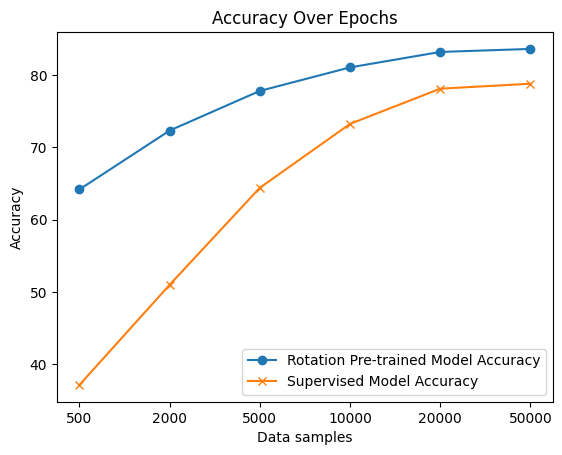

In [26]:
import matplotlib.pyplot as plt

x_data = np.zeros(0)
rot_data = np.zeros(0)
supervised_data = np.zeros(0)
for key, item in accuracy.items():
    x_data = np.append(x_data, key)
    rot, supervised = item
    rot_data = np.append(rot_data, rot)
    supervised_data = np.append(supervised_data, supervised)
    
plt.plot(x_data, rot_data, label='Rotation Pre-trained Model Accuracy', marker='o')
plt.plot(x_data, supervised_data, label='Supervised Model Accuracy', marker='x')

plt.xlabel('Data samples')
plt.ylabel('Accuracy') 

plt.title('Accuracy Over Epochs') 
plt.legend()
plt.show()


In [27]:
from torchvision.models import mobilenet_v2
mobilev2_model = mobilenet_v2(pretrained=True)
mobilev2_model = mobilev2_model.to(device)

/home/changl25/miniconda3/envs/StableVITON/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/changl25/miniconda3/envs/StableVITON/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [28]:
transform_train_mobile = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

transform_test_mobile = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

batch_size = 128

trainset_mobile = CIFAR10Rotation(root='./data', train=True,
                                        download=True, transform=transform_train_mobile)
trainloader_mobile = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset_mobile = CIFAR10Rotation(root='./data', train=False,
                                       download=True, transform=transform_test_mobile)
testloader_mobile = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

print("train size: ", len(trainloader_mobile), "test size: ", len(testloader_mobile))

Files already downloaded and verified
Files already downloaded and verified
train size:  391 test size:  79


In [32]:
num_epochs=75
decay_epochs=15
init_lr=1e-5
task='rotation'
scheduler_cls = torch.optim.lr_scheduler.StepLR
scheduler_params = {'step_size': 30, 'gamma': 0.1}

optimizer = torch.optim.Adam(mobilev2_model.parameters(), weight_decay=0.0008)
criterion = nn.CrossEntropyLoss().to(device)

In [ ]:
train(mobilev2_model, trainloader_mobile, criterion, optimizer, num_epochs=num_epochs, decay_epochs=decay_epochs, init_lr=init_lr, task=task)

# TODO: Save the model
net_name = "mobilev2_lr{}_epoch{}_{}.pth.tar".format(init_lr, num_epochs, task)
save_path = os.path.join(work_dir, "model")
os.makedirs(save_path, exist_ok=True)
torch.save(mobilev2_model.state_dict(), os.path.join(save_path, net_name))

In [33]:
# TODO: Save the model
net_name = "mobilev2_lr{}_epoch{}_{}.pth.tar".format(init_lr, num_epochs, task)
save_path = os.path.join(work_dir, "model")
# os.makedirs(save_path, exist_ok=True)
# torch.save(mobilev2_model.state_dict(), os.path.join(save_path, net_name))

In [30]:
for name, module in mobilev2_model.named_modules():
    print("name: ", name)
    for key, value in module.named_parameters():
        print(f"{name}: {key}")
total_params = sum(p.numel() for p in mobilev2_model.parameters())
trainable_params = sum(p.numel() for p in mobilev2_model.parameters() if p.requires_grad)
print(f"Total number of parameters: {total_params}")
print(f"Total number of trainable parameters: {trainable_params}")


total_params = sum(p.numel() for p in net.parameters())
trainable_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f"Total number of parameters: {total_params}")
print(f"Total number of trainable parameters: {trainable_params}")


name:  
: features.0.0.weight
: features.0.1.weight
: features.0.1.bias
: features.1.conv.0.0.weight
: features.1.conv.0.1.weight
: features.1.conv.0.1.bias
: features.1.conv.1.weight
: features.1.conv.2.weight
: features.1.conv.2.bias
: features.2.conv.0.0.weight
: features.2.conv.0.1.weight
: features.2.conv.0.1.bias
: features.2.conv.1.0.weight
: features.2.conv.1.1.weight
: features.2.conv.1.1.bias
: features.2.conv.2.weight
: features.2.conv.3.weight
: features.2.conv.3.bias
: features.3.conv.0.0.weight
: features.3.conv.0.1.weight
: features.3.conv.0.1.bias
: features.3.conv.1.0.weight
: features.3.conv.1.1.weight
: features.3.conv.1.1.bias
: features.3.conv.2.weight
: features.3.conv.3.weight
: features.3.conv.3.bias
: features.4.conv.0.0.weight
: features.4.conv.0.1.weight
: features.4.conv.0.1.bias
: features.4.conv.1.0.weight
: features.4.conv.1.1.weight
: features.4.conv.1.1.bias
: features.4.conv.2.weight
: features.4.conv.3.weight
: features.4.conv.3.bias
: features.5.conv

In [34]:
model_path = os.path.join(save_path, net_name)
mobile_cls_model = mobilenet_v2(num_classes=10, pretrained=False).to(device)

frozen_layers = ["features.18", "classifier"]



mobile_cls_model = load_layers(mobile_cls_model, torch.load(model_path, map_location=device), frozen_layers)
run_test(net, testloader_mobile, criterion, task)


TESTING:
Accuracy of the network on the 10000 test images: 78.26 %
Average loss on the 10000 test images: 0.553


0.7826

In [35]:
num_epochs=50
decay_epochs=15
init_lr=5 * 1e-5
task='classification'
scheduler_cls = torch.optim.lr_scheduler.StepLR
scheduler_params = {'step_size': 15, 'gamma': 0.2}
optimizer = torch.optim.Adam(mobile_cls_model.parameters(), weight_decay=0.0008)
# optimizer = torch.optim.SGD(net.parameters(), lr= init_lr, weight_decay=0.0005, momentum=0.9)
criterion = nn.CrossEntropyLoss().to(device)

In [36]:
train(mobile_cls_model, trainloader_mobile, criterion, optimizer, num_epochs=num_epochs, decay_epochs=decay_epochs, init_lr=init_lr, task=task, \
    scheduler_cls=scheduler_cls, scheduler_params=scheduler_params)
run_test(mobile_cls_model, testloader_mobile, criterion, task)

[1,   100] lr: 5e-05 loss: 1.580 acc: 46.86 time: 7.83
[1,   200] lr: 5e-05 loss: 1.135 acc: 59.81 time: 7.34
[1,   300] lr: 5e-05 loss: 1.039 acc: 63.14 time: 7.30
TESTING:
Accuracy of the network on the 10000 test images: 68.00 %
Average loss on the 10000 test images: 0.909
Current best accuracy of the testing is 68.0% at epoch 0
[2,   100] lr: 5e-05 loss: 0.926 acc: 67.69 time: 7.78
[2,   200] lr: 5e-05 loss: 0.896 acc: 68.48 time: 7.35
[2,   300] lr: 5e-05 loss: 0.871 acc: 69.66 time: 7.34
TESTING:
Accuracy of the network on the 10000 test images: 71.48 %
Average loss on the 10000 test images: 0.823
Current best accuracy of the testing is 71.48% at epoch 1
[3,   100] lr: 5e-05 loss: 0.812 acc: 71.44 time: 7.49
[3,   200] lr: 5e-05 loss: 0.805 acc: 72.05 time: 7.22
[3,   300] lr: 5e-05 loss: 0.793 acc: 72.07 time: 7.27
TESTING:
Accuracy of the network on the 10000 test images: 73.00 %
Average loss on the 10000 test images: 0.770
Current best accuracy of the testing is 73.0% at epoch

0.82

In [60]:
from thop import profile
def remove_hooks(m):
    if hasattr(m, 'total_ops'):
        del m.total_ops
    if hasattr(m, 'total_params'):
            del m.total_params
rot_net.eval()
mobile_cls_model.eval()
with torch.no_grad():
    image1, _, _, _ = next(iter(testloader))
    image1 = image1.to(device)
    image2, _, _, _ = next(iter(testloader_mobile))
    image2 = image2.to(device)
    flops, params = profile(rot_net, inputs=(image1, ), verbose=False)
    print(f"Total FLOPs: {flops}")
    print(f"Total Params: {params}")
    rot_net.apply(remove_hooks)
    flops, params = profile(mobile_cls_model, inputs=(image2, ), verbose=False)
    print(f"Total FLOPs: {flops}")
    print(f"Total Params: {params}")
    mobile_cls_model.apply(remove_hooks)
    



Total FLOPs: 744407040.0
Total Params: 11181642.0
Total FLOPs: 853770240.0
Total Params: 2236682.0


In [64]:
with torch.no_grad():
    start_time = time.time()
    net(image2)
    print("time: ", (time.time() - start_time) / (image1.shape[0]))
    start_time = time.time()
    mobile_cls_model(image2)
    print("time: ", (time.time() - start_time) / (image2.shape[0]))


time:  0.0033051013946533204
time:  0.0003282390534877777
